In [1]:
%cd ..

/Users/juansegundohevia/Documents/repos/rice-datathon-2024-chevron


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


In [5]:
data_original = pd.read_csv("data/training.csv")
stages_to_estimate = "total"

data = data_original.copy()

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

if stages_to_estimate == "total":
    predictive_cols = [
        "total_proppant",
        "total_fluid",
        "bin_lateral_length",
        "frac_seasoning",
        "gross_perforated_length"
    ]
    target_cols = ["number_of_stages"]
elif stages_to_estimate == "lateral":
    predictive_cols = [
        "total_proppant",
        "total_fluid",
        # "frac_seasoning",
        # "true_vertical_depth",
        "gross_perforated_length"
    ]
    target_cols = ["bin_lateral_length", "average_stage_length"]
    
data = data[predictive_cols + target_cols]

# Compute the log of frac_seasoning to make it less skewed
data["frac_seasoning"] = np.log(data["frac_seasoning"] + 1)

# Impute NaNs in all columns except the ones that will be targets
for col in predictive_cols:
    if col not in target_cols:
        data[col] = data[col].fillna(data[col].mean())

# Now filter where the targets are NaN, since we can't use them
data = data.dropna(subset=target_cols)

if stages_to_estimate == "total":
    y = data["number_of_stages"]
    X = data.drop(["number_of_stages"], axis=1)
elif stages_to_estimate == "lateral":
    y = data["average_stage_length"] * data["bin_lateral_length"]
    X = data.drop(["average_stage_length", "bin_lateral_length"], axis=1)

pipeline.fit(X, y)

X_test = data_original[predictive_cols].dropna()
y_test = pd.Series(pipeline.predict(X_test), index=X_test.index)
y_test = y_test.rename(f"predicted_number_of_{stages_to_estimate}_stages")

In [9]:
data_original.number_of_stages.to_frame()

,number_of_stages
0,NaN
1,NaN
2,12.0
3,11.0
4,NaN
...,...
29687,NaN
29688,NaN
29689,NaN
29690,NaN


In [10]:
y_test

2        60.159200
35       25.901595
39       24.513505
44       20.236157
45       36.282276
           ...    
29479    76.575643
29496    53.476471
29497    39.931848
29498    55.069372
29617    33.743452
Name: predicted_number_of_total_stages, Length: 14291, dtype: float64

In [24]:
import pickle as pkl

with open("model/nos_prediction.pkl", "wb") as f:
    pkl.dump(pipeline, f)

In [3]:
preprocessed = pd.read_csv("data/preprocessed.csv")
preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19306 entries, 0 to 19305
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   surface_x                  19306 non-null  float64
 1   surface_y                  19306 non-null  float64
 2   gross_perforated_length    19148 non-null  float64
 3   number_of_stages           2643 non-null   float64
 4   total_proppant             17912 non-null  float64
 5   total_fluid                17866 non-null  float64
 6   true_vertical_depth        19201 non-null  float64
 7   ffs_frac_type              14310 non-null  object 
 8   bin_lateral_length         19148 non-null  float64
 9   relative_well_position     19306 non-null  object 
 10  batch_frac_classification  19306 non-null  object 
 11  well_family_relationship   19306 non-null  object 
 12  frac_seasoning             14479 non-null  float64
 13  OilPeakRate                19306 non-null  flo

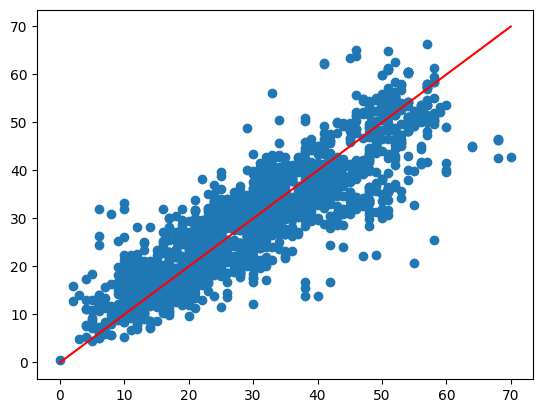

In [9]:
data = pd.read_csv("data/training.csv")

cols = [
    "total_proppant",
    "total_fluid",
    "bin_lateral_length",
    "frac_seasoning",
    # "average_stage_length",
    # "true_vertical_depth",
    "gross_perforated_length",
    "number_of_stages"
]

# Compute the log of frac_seasoning
data["frac_seasoning"] = np.log(data["frac_seasoning"] + 1)

# Impute NaNs in all columns except number_of_stages
for col in cols:
    if col != "number_of_stages" and col != "average_stage_length":
        data[col] = data[col].fillna(data[col].mean())

# Now filter where the targets are NaN
data = data[cols].dropna(subset=[
    # "average_stage_length", 
    "number_of_stages"
])

y = data["number_of_stages"]
X = data.drop(["number_of_stages"], axis=1)

scaler = StandardScaler()
X = scaler.fit_transform(X)

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)
plt.scatter(y, y_pred)
plt.plot([0, 70], [0, 70], color="red")
plt.show()


In [13]:
feats = ["total_proppant",
        "total_fluid",
        "bin_lateral_length",
        "frac_seasoning",
        "gross_perforated_length",]

output = preprocessed.dropna(subset=feats + ["number_of_stages"])

output["pred_nos"] = model.predict(scaler.transform(output[feats]))
output

/var/folders/2c/s1dc7gqn0jz4dls2kprq822m0000gn/T/ipykernel_94072/3503118803.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output["pred_nos"] = model.predict(scaler.transform(output[feats]))


,surface_x,surface_y,gross_perforated_length,number_of_stages,total_proppant,total_fluid,true_vertical_depth,ffs_frac_type,bin_lateral_length,relative_well_position,batch_frac_classification,well_family_relationship,frac_seasoning,OilPeakRate,pred_nos
2,1.379916e+06,7.178450e+05,3810.039370,12.0,286571.42860,1.621424e+06,8801.181102,NaN,1.0,Standalone Well,Non-Batch Frac,Standalone Well,92.0,10.785716,60.159200
35,1.384891e+06,7.065820e+05,4017.716535,11.0,135363.78570,1.016599e+06,8605.314961,NaN,1.0,Outer Well,Non-Batch Frac,Infill Child Well,28.0,83.512989,25.901595
289,1.032837e+06,6.980786e+05,3923.228346,14.0,451393.64290,1.919215e+06,8500.984252,Undefined,1.0,Standalone Well,Non-Batch Frac,Standalone Well,9.0,184.642886,20.326464
292,1.028373e+06,7.056649e+05,3899.606299,14.0,448267.00000,1.895077e+06,8627.952756,Undefined,1.0,Standalone Well,Non-Batch Frac,Standalone Well,6.0,223.857178,18.658507
306,1.036476e+06,6.448720e+05,4490.157480,15.0,336784.64290,1.647635e+06,6171.259843,NaN,1.0,Standalone Well,Non-Batch Frac,Standalone Well,135.0,41.392864,84.943236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19279,9.304857e+05,1.057307e+06,1523.622047,5.0,82245.78571,3.200533e+05,8255.905512,Undefined,0.0,Standalone Well,Batch-Sequential Frac,Standalone Well,106.0,68.605963,58.838323
19293,9.328000e+05,1.058747e+06,1601.377953,7.0,78457.92857,2.209894e+05,8387.795276,Undefined,0.0,Inner Well,Batch-Sequential Frac,Infill Child Well,29.0,9.361509,19.668411
19295,9.313518e+05,1.060801e+06,1379.921260,6.0,12136.50000,2.325137e+05,8216.535433,Undefined,0.0,Inner Well,Batch-Sequential Frac,Infill Child Well,32.0,4.157937,19.733284
19297,9.326688e+05,1.059044e+06,1537.401575,6.0,36657.85714,3.105691e+05,8313.976378,Slickwater Crosslink Hybrid,0.0,Standalone Well,Non-Batch Frac,Standalone Well,43.0,30.071433,26.220052


<Axes: xlabel='pred_nos', ylabel='number_of_stages'>

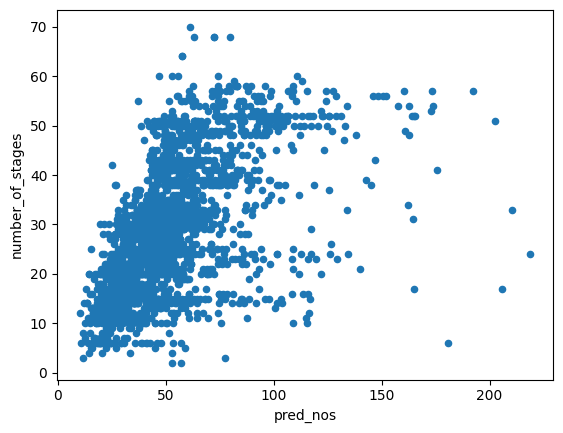

In [14]:
output.plot(x="pred_nos", y="number_of_stages", kind="scatter")